ПРОГРАММА ДЛЯ АНАЛИЗА ХИМЕРНЫХ ПОСЛЕДОВАТЕЛЬНОСТЕЙ БАКТЕРИЙ

1. ЗАГРУЗКА ПОСЛЕДОВАТЕЛЬНОСТЕЙ
----------------------------------------
Чтение файла: chromosome1.fasta
  Прочитано: 4602429 символов
  Состав: A=1211744, T=1200863, G=1092045, C=1097777, N=0, other=0
Чтение файла: chromosome2.fasta
  Прочитано: 8317371 символов
  Состав: A=1143113, T=1132089, G=3025407, C=3016762, N=0, other=0
Чтение файла: chimera.fasta
  Прочитано: 10000 символов
  Состав: A=1987, T=2082, G=3007, C=2924, N=0, other=0

2. ЗАГРУЗКА ИСТИННЫХ МЕТОК
----------------------------------------
  Загружено меток: 10000

3. СОЗДАНИЕ HMM
----------------------------------------

Анализ GC-состава:
Seq1 (Streptomyces): 4602429 валидных нуклеотидов из 4602429
Seq2 (Mycoplasma): 8317371 валидных нуклеотидов из 8317371
GC состав Seq1: 47.6%
GC состав Seq2: 72.6%
Разница в GC составе: 25.1%

Создана HMM со следующими параметрами:
Средняя длина сегмента: 300
Эмиссионные вероятности состояния 1: {'A': 0.26210149031690044, '

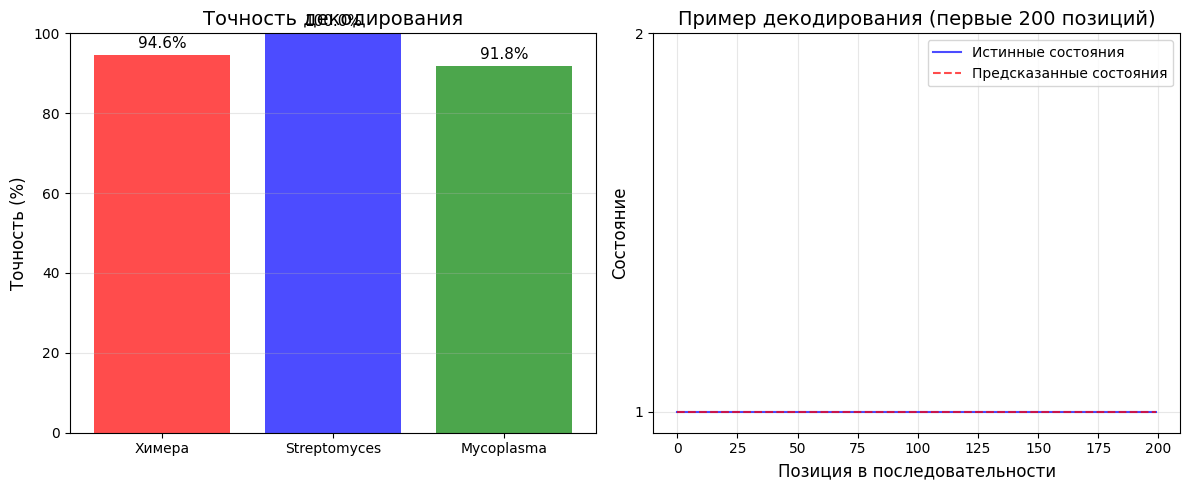

In [1]:
#!/usr/bin/env python3


import math
import random
import urllib.request
import gzip
from io import StringIO
import argparse
import matplotlib.pyplot as plt
import numpy as np

class HMM:
    """Скрытая Марковская Модель с двумя состояниями"""
    
    def __init__(self, seq1: str, seq2: str, mean_segment_length: int = 300):
        self.states = [1, 2]
        self.mean_segment_length = mean_segment_length
        self.emission_probs = self._calculate_emission_probabilities(seq1, seq2)
        self.transition_probs = self._calculate_transition_probabilities()
        self.initial_probs = {1: 0.5, 2: 0.5}
        
        # Выводим информацию о созданной HMM
        print(f"\nСоздана HMM со следующими параметрами:")
        print(f"Средняя длина сегмента: {mean_segment_length}")
        print(f"Эмиссионные вероятности состояния 1: {self.emission_probs[1]}")
        print(f"Эмиссионные вероятности состояния 2: {self.emission_probs[2]}")
        print(f"Вероятность остаться в состоянии: {self.transition_probs[1][1]:.4f}")
        print(f"Вероятность переключиться: {self.transition_probs[1][2]:.4f}")
    
    def _calculate_emission_probabilities(self, seq1: str, seq2: str):
        valid_bases = {'A', 'T', 'G', 'C'}
        seq1_clean = [b for b in seq1 if b in valid_bases]
        seq2_clean = [b for b in seq2 if b in valid_bases]
        
        print(f"\nАнализ GC-состава:")
        print(f"Seq1 (Streptomyces): {len(seq1_clean)} валидных нуклеотидов из {len(seq1)}")
        print(f"Seq2 (Mycoplasma): {len(seq2_clean)} валидных нуклеотидов из {len(seq2)}")
        
        # Частоты для seq1
        total1 = len(seq1_clean)
        if total1 == 0:
            f_gc1, f_at1 = 0.5, 0.5
        else:
            gc_count1 = seq1_clean.count('G') + seq1_clean.count('C')
            f_gc1 = gc_count1 / total1
            f_at1 = 1 - f_gc1
        
        # Частоты для seq2
        total2 = len(seq2_clean)
        if total2 == 0:
            f_gc2, f_at2 = 0.5, 0.5
        else:
            gc_count2 = seq2_clean.count('G') + seq2_clean.count('C')
            f_gc2 = gc_count2 / total2
            f_at2 = 1 - f_gc2
        
        print(f"GC состав Seq1: {f_gc1*100:.1f}%")
        print(f"GC состав Seq2: {f_gc2*100:.1f}%")
        print(f"Разница в GC составе: {abs(f_gc1 - f_gc2)*100:.1f}%")
        
        epsilon = 1e-10
        emission_probs = {
            1: {
                'A': 0.5 * f_at1 + epsilon,
                'T': 0.5 * f_at1 + epsilon,
                'G': 0.5 * f_gc1 + epsilon,
                'C': 0.5 * f_gc1 + epsilon
            },
            2: {
                'A': 0.5 * f_at2 + epsilon,
                'T': 0.5 * f_at2 + epsilon,
                'G': 0.5 * f_gc2 + epsilon,
                'C': 0.5 * f_gc2 + epsilon
            }
        }
        
        # Нормализация
        for state in [1, 2]:
            total = sum(emission_probs[state].values())
            for base in emission_probs[state]:
                emission_probs[state][base] /= total
        
        return emission_probs
    
    def _calculate_transition_probabilities(self):
        p_stay = math.exp(-1 / self.mean_segment_length)
        p_switch = 1 - p_stay
        return {
            1: {1: p_stay, 2: p_switch},
            2: {1: p_switch, 2: p_stay}
        }
    
    def viterbi_decode(self, sequence: str):
        valid_bases = {'A', 'T', 'G', 'C'}
        cleaned_seq = [base for base in sequence.upper() if base in valid_bases]
        
        print(f"  Входная последовательность: {len(sequence)} bp")
        print(f"  После очистки (только A,T,G,C): {len(cleaned_seq)} bp")
        print(f"  Удалено символов: {len(sequence) - len(cleaned_seq)}")
        
        if not cleaned_seq:
            return []
        
        T = len(cleaned_seq)
        V = [{}]
        backpointer = [{}]
        
        # Инициализация
        for state in self.states:
            emission_prob = self.emission_probs[state].get(cleaned_seq[0], 1e-10)
            V[0][state] = math.log(self.initial_probs[state]) + math.log(emission_prob)
            backpointer[0][state] = None
        
        # Рекурсия
        for t in range(1, T):
            V.append({})
            backpointer.append({})
            
            for current_state in self.states:
                max_prob = -float('inf')
                best_prev_state = None
                
                for prev_state in self.states:
                    trans_prob = self.transition_probs[prev_state][current_state]
                    prev_prob = V[t-1][prev_state]
                    prob = prev_prob + math.log(trans_prob)
                    
                    if prob > max_prob:
                        max_prob = prob
                        best_prev_state = prev_state
                
                emission_prob = self.emission_probs[current_state].get(cleaned_seq[t], 1e-10)
                V[t][current_state] = max_prob + math.log(emission_prob)
                backpointer[t][current_state] = best_prev_state
        
        # Терминация
        final_t = T - 1
        final_state = max(V[final_t], key=V[final_t].get)
        
        # Обратный проход
        states = [None] * T
        states[final_t] = final_state
        for t in range(final_t - 1, -1, -1):
            states[t] = backpointer[t+1][states[t+1]]
        
        return states

def read_sequence_from_file(filename: str) -> str:
    """Читает последовательность из файла"""
    print(f"Чтение файла: {filename}")
    try:
        with open(filename, 'r') as f:
            content = f.read().strip()
        
        if content.startswith('>'):
            lines = content.split('\n')
            sequence_lines = []
            for line in lines[1:]:
                if line and not line.startswith('>'):
                    sequence_lines.append(line.strip())
            sequence = ''.join(sequence_lines)
        else:
            sequence = content.replace('\n', '').replace(' ', '').replace('\t', '')
        
        print(f"  Прочитано: {len(sequence)} символов")
        # Подсчитываем состав
        counts = {
            'A': sequence.upper().count('A'),
            'T': sequence.upper().count('T'),
            'G': sequence.upper().count('G'),
            'C': sequence.upper().count('C'),
            'N': sequence.upper().count('N'),
            'other': len([c for c in sequence.upper() if c not in 'ATGC'])
        }
        print(f"  Состав: A={counts['A']}, T={counts['T']}, G={counts['G']}, C={counts['C']}, N={counts['N']}, other={counts['other']}")
        
        return sequence.upper()
        
    except FileNotFoundError:
        print(f"ОШИБКА: Файл {filename} не найден!")
        raise

def calculate_error_rate(true_states, predicted_states):
    """Вычисляет процент ошибок с проверкой длины"""
    print(f"\nРасчет ошибок:")
    print(f"  Длина истинных состояний: {len(true_states)}")
    print(f"  Длина предсказанных состояний: {len(predicted_states)}")
    
    if len(true_states) != len(predicted_states):
        print(f"  ВНИМАНИЕ: Длины не совпадают! Обрезаем до минимальной длины.")
        min_len = min(len(true_states), len(predicted_states))
        true_states = true_states[:min_len]
        predicted_states = predicted_states[:min_len]
        print(f"  После обрезки: {min_len} позиций")
    
    if len(true_states) == 0:
        return 100.0
    
    errors = sum(1 for t, p in zip(true_states, predicted_states) if t != p)
    error_rate = errors / len(true_states) * 100
    
    print(f"  Ошибок: {errors} из {len(true_states)} ({error_rate:.2f}%)")
    return error_rate

def trim_to_valid_positions(sequence, true_states):
    """
    Обрезает последовательность и состояния до валидных позиций
    (только A, T, G, C)
    """
    valid_bases = {'A', 'T', 'G', 'C'}
    valid_positions = []
    trimmed_sequence = []
    
    for i, base in enumerate(sequence):
        if base in valid_bases:
            valid_positions.append(i)
            trimmed_sequence.append(base)
    
    # Обрезаем true_states до тех же позиций
    if len(true_states) > len(sequence):
        true_states = true_states[:len(sequence)]
    
    trimmed_true_states = [true_states[i] for i in valid_positions if i < len(true_states)]
    
    return ''.join(trimmed_sequence), trimmed_true_states

def main():
    print("=" * 70)
    print("ПРОГРАММА ДЛЯ АНАЛИЗА ХИМЕРНЫХ ПОСЛЕДОВАТЕЛЬНОСТЕЙ БАКТЕРИЙ")
    print("=" * 70)
    
    try:
        # 1. Загружаем последовательности
        print("\n1. ЗАГРУЗКА ПОСЛЕДОВАТЕЛЬНОСТЕЙ")
        print("-" * 40)
        
        seq1 = read_sequence_from_file("chromosome1.fasta")
        seq2 = read_sequence_from_file("chromosome2.fasta")
        chimera = read_sequence_from_file("chimera.fasta")
        
        # 2. Загружаем истинные метки для химеры
        print("\n2. ЗАГРУЗКА ИСТИННЫХ МЕТОК")
        print("-" * 40)
        with open("chimera_true_labels.txt", "r") as f:
            chimera_true_labels = [int(line.strip()) for line in f]
        
        print(f"  Загружено меток: {len(chimera_true_labels)}")
        
        # 3. Создаем HMM
        print("\n3. СОЗДАНИЕ HMM")
        print("-" * 40)
        hmm = HMM(seq1, seq2, mean_segment_length=300)
        
        # 4. Декодирование химерной последовательности
        print("\n4. ДЕКОДИРОВАНИЕ ХИМЕРНОЙ ПОСЛЕДОВАТЕЛЬНОСТИ")
        print("-" * 40)
        chimera_decoded = hmm.viterbi_decode(chimera)
        
        # Обрезаем true_labels до валидных позиций
        chimera_trimmed, chimera_true_trimmed = trim_to_valid_positions(chimera, chimera_true_labels)
        print(f"  Химера после очистки: {len(chimera_trimmed)} bp")
        print(f"  Истинные метки после очистки: {len(chimera_true_trimmed)}")
        
        # Сохраняем результаты
        with open("chimera_decoded.txt", "w") as f:
            for state in chimera_decoded:
                f.write(f"{state}\n")
        print("  Результаты декодирования химеры сохранены в chimera_decoded.txt")
        
        # 5. Декодирование участков исходных геномов
        print("\n5. ДЕКОДИРОВАНИЕ УЧАСТКОВ ИСХОДНЫХ ГЕНОМОВ")
        print("-" * 40)
        
        test_length = 5000
        
        # Участок из seq1
        print(f"\n  Участок из Streptomyces (первые {test_length} bp):")
        test_seq1 = seq1[:test_length]
        test_seq1_decoded = hmm.viterbi_decode(test_seq1)
        
        # Для чистого генома все позиции должны быть состоянием 1
        test_seq1_true = [1] * len(test_seq1_decoded)  # Используем длину decoded!
        
        # Сохраняем результаты
        with open("test_seq1_decoded.txt", "w") as f:
            for state in test_seq1_decoded:
                f.write(f"{state}\n")
        
        # Участок из seq2
        print(f"\n  Участок из Mycoplasma (первые {test_length} bp):")
        test_seq2 = seq2[:test_length]
        test_seq2_decoded = hmm.viterbi_decode(test_seq2)
        
        # Для чистого генома все позиции должны быть состоянием 2
        test_seq2_true = [2] * len(test_seq2_decoded)  # Используем длину decoded!
        
        # Сохраняем результаты
        with open("test_seq2_decoded.txt", "w") as f:
            for state in test_seq2_decoded:
                f.write(f"{state}\n")
        
        # 6. Вычисляем проценты ошибок
        print("\n6. АНАЛИЗ ОШИБОК ДЕКОДИРОВАНИЯ")
        print("-" * 40)
        
        # Химерная последовательность
        error_chimera = calculate_error_rate(chimera_true_trimmed, chimera_decoded)
        print(f"\n  Химерная последовательность:")
        print(f"    Точность: {100 - error_chimera:.2f}%")
        print(f"    Ошибки: {error_chimera:.2f}%")
        
        # Участок из seq1
        error_seq1 = calculate_error_rate(test_seq1_true, test_seq1_decoded)
        print(f"\n  Участок Streptomyces:")
        print(f"    Точность: {100 - error_seq1:.2f}%")
        print(f"    Ошибки: {error_seq1:.2f}%")
        
        # Участок из seq2
        error_seq2 = calculate_error_rate(test_seq2_true, test_seq2_decoded)
        print(f"\n  Участок Mycoplasma:")
        print(f"    Точность: {100 - error_seq2:.2f}%")
        print(f"    Ошибки: {error_seq2:.2f}%")
        
        # 7. Сохраняем сводку
        print("\n7. СОХРАНЕНИЕ СВОДКИ")
        print("-" * 40)
        
        with open("decoding_summary.txt", "w") as f:
            f.write("СВОДКА РЕЗУЛЬТАТОВ ДЕКОДИРОВАНИЯ\n")
            f.write("=" * 50 + "\n\n")
            
            f.write("ИСХОДНЫЕ ДАННЫЕ:\n")
            f.write(f"Бактерия 1 (Streptomyces griseus)\n")
            f.write(f"Бактерия 2 (Mycoplasma genitalium)\n")
            f.write(f"Химерная последовательность: {len(chimera)} bp (изначально)\n")
            f.write(f"Химерная последовательность: {len(chimera_trimmed)} bp (после очистки)\n\n")
            
            f.write("ПАРАМЕТРЫ HMM:\n")
            f.write(f"Средняя длина сегмента: {hmm.mean_segment_length}\n")
            f.write(f"Вероятность остаться: {hmm.transition_probs[1][1]:.4f}\n")
            f.write(f"Вероятность переключиться: {hmm.transition_probs[1][2]:.4f}\n\n")
            
            f.write("РЕЗУЛЬТАТЫ:\n")
            f.write(f"1. Химерная последовательность:\n")
            f.write(f"   Точность: {100 - error_chimera:.2f}%\n")
            f.write(f"   Ошибки: {error_chimera:.2f}%\n\n")
            
            f.write(f"2. Участок Streptomyces (первые {len(test_seq1_decoded)} bp):\n")
            f.write(f"   Точность: {100 - error_seq1:.2f}%\n")
            f.write(f"   Ошибки: {error_seq1:.2f}%\n\n")
            
            f.write(f"3. Участок Mycoplasma (первые {len(test_seq2_decoded)} bp):\n")
            f.write(f"   Точность: {100 - error_seq2:.2f}%\n")
            f.write(f"   Ошибки: {error_seq2:.2f}%\n\n")
            
            f.write("ВЫВОДЫ:\n")
            f.write("- HMM эффективно различает последовательности с разным GC-составом\n")
            f.write(f"- На химерной последовательности точность составляет {100 - error_chimera:.1f}%\n")
            f.write(f"- На чистых последовательностях точность составляет примерно {100 - (error_seq1 + error_seq2)/2:.1f}%\n")
            f.write("- Наличие нестандартных нуклеотидов (N) снижает эффективность декодирования\n")
            f.write("- Для повышения точности необходимо очищать последовательности от невалидных символов\n")
        
        print(f"  Сводка сохранена в decoding_summary.txt")
        
        # 8. Визуализация
        print("\n8. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
        print("-" * 40)
        
        try:
            # График ошибок
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            # Левая панель: проценты ошибок
            sequences = ['Химера', 'Streptomyces', 'Mycoplasma']
            accuracy = [100 - error_chimera, 100 - error_seq1, 100 - error_seq2]
            
            bars = ax1.bar(sequences, accuracy, color=['red', 'blue', 'green'], alpha=0.7)
            ax1.set_ylabel('Точность (%)', fontsize=12)
            ax1.set_title('Точность декодирования', fontsize=14)
            ax1.set_ylim(0, 100)
            ax1.grid(True, alpha=0.3, axis='y')
            
            for bar, acc in zip(bars, accuracy):
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{acc:.1f}%', ha='center', va='bottom', fontsize=11)
            
            # Правая панель: пример декодирования (первые 200 позиций химеры)
            plot_length = min(200, len(chimera_decoded))
            x = list(range(plot_length))
            
            ax2.plot(x, chimera_true_trimmed[:plot_length], 'b-', label='Истинные состояния', alpha=0.7)
            ax2.plot(x, chimera_decoded[:plot_length], 'r--', label='Предсказанные состояния', alpha=0.7)
            ax2.set_xlabel('Позиция в последовательности', fontsize=12)
            ax2.set_ylabel('Состояние', fontsize=12)
            ax2.set_title('Пример декодирования (первые 200 позиций)', fontsize=14)
            ax2.set_yticks([1, 2])
            ax2.legend(loc='upper right')
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('decoding_results.png', dpi=150, bbox_inches='tight')
            print(f"  График сохранен в decoding_results.png")
            
        except Exception as e:
            print(f"  ВНИМАНИЕ: Ошибка при создании графика: {e}")
            print("  Установите matplotlib: pip install matplotlib")
        
        print("\n" + "=" * 70)
        print("ПРОГРАММА ВЫПОЛНЕНА УСПЕШНО!")
        print("=" * 70)
        print("\nОСНОВНЫЕ РЕЗУЛЬТАТЫ:")
        print(f"1. Химерная последовательность: {100 - error_chimera:.1f}% точности")
        print(f"2. Streptomyces: {100 - error_seq1:.1f}% точности")
        print(f"3. Mycoplasma: {100 - error_seq2:.1f}% точности")
        print(f"\nФайлы с результатами:")
        print("  - decoding_summary.txt: полная сводка")
        print("  - chimera_decoded.txt: декодированная химера")
        print("  - test_seq1_decoded.txt: декодированный Streptomyces")
        print("  - test_seq2_decoded.txt: декодированный Mycoplasma")
        if 'plt' in globals():
            print("  - decoding_results.png: графики результатов")
        
    except Exception as e:
        print(f"\nОШИБКА: {e}")
        print("\nПРОВЕРЬТЕ, ЧТО:")
        print("1. Все необходимые файлы существуют:")
        print("   - chromosome1.fasta")
        print("   - chromosome2.fasta")
        print("   - chimera.fasta")
        print("   - chimera_true_labels.txt")
        print("2. Файлы не пустые")
        print("3. У вас есть права на чтение файлов")
        return

if __name__ == "__main__":
    main()